# Midterm 413A-2022


In [2]:
name = input("What is your name? ")
sid = input("What is your student ID? ")
print("Name: " + name + "\nStudent ID: " + sid)

What is your name? Poudel Birat
What is your student ID? 201847546
Name: Poudel Birat
Student ID: 201847546


## Import necessary libraries

In [3]:
%config InlineBackend.figure_format='retina'
# Python libraries
import random
from collections import Counter
from tqdm.notebook import tqdm

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn import preprocessing
from sklearn import model_selection

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [4]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42

## Load preprocessed data

In [5]:
import gdown
id = "16X_2ujGBW6ss4W6l8ifHDgmyJlNAfam1"

output = "fomc_features.zip"
gdown.cached_download(id=id, path=output, postprocess=gdown.extractall)
data_dir = './features/'

Cached Downloading: fomc_features.zip
Downloading...
From: https://drive.google.com/uc?id=16X_2ujGBW6ss4W6l8ifHDgmyJlNAfam1
To: /root/.cache/gdown/tmp2wewqc0s/dl
100%|██████████| 37.6M/37.6M [00:00<00:00, 227MB/s]


In [6]:
# Load previously processed non-text data
# Load data
train_df = pd.read_parquet(data_dir + 'econ_train_small.parquet')
train_df

,target,prev_decision,GDP_diff_prev,PMI,EMP_diff_prev,RSALES_diff_year,UNEMP_diff_prev,HSALES_diff_year,Inertia_diff,Balanced_diff
date,,,,,,,,,,
1982-10-05,Cut,0.0,0.456199,38.8,-0.201426,2.094256,3.061224,42.307692,0.0,0.0
1982-11-16,Cut,-1.0,-0.382299,39.4,-0.309476,2.094256,2.970297,34.831461,0.0,0.0
1982-12-21,Hold,-1.0,-0.382299,39.2,-0.136097,2.094256,3.846154,45.026178,0.0,0.0
1983-01-14,Hold,0.0,-0.382299,42.8,-0.016895,2.094256,0.000000,14.004376,0.0,0.0
1983-01-21,Hold,0.0,-0.382299,42.8,-0.016895,2.094256,0.000000,14.004376,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-11-03,Hold,0.0,0.570948,60.5,0.288624,8.474656,-9.615385,-26.135217,0.0,0.0
2021-12-15,Hold,0.0,0.570948,60.6,0.437147,10.977142,-8.695652,-11.163337,0.0,0.0
2022-01-26,Hold,0.0,0.570948,58.8,0.395555,9.101289,-7.142857,-3.673938,0.0,0.0


In [7]:
# List of Non-text columns
nontext_columns = train_df.drop(columns=['target']).columns.tolist()
nontext_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI',
 'EMP_diff_prev',
 'RSALES_diff_year',
 'UNEMP_diff_prev',
 'HSALES_diff_year',
 'Inertia_diff',
 'Balanced_diff']

In [8]:
# Load text data
fomc_corpus = pd.read_parquet(data_dir + 'fomc_corpus.parquet')
fomc_corpus

,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words
0,0,A meeting of the Federal Open Market Committee...,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-02-18,0.0,3.00,10387
1,1,A meeting of the Federal Open Market Committee...,1993-03-23,fomc_minutes,1993-03-23,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-05-18,0.0,3.00,5788
2,2,A meeting of the Federal Open Market Committee...,1993-05-18,fomc_minutes,1993-05-18,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-07-07,0.0,3.00,5008
3,3,A meeting of the Federal Open Market Committee...,1993-07-07,fomc_minutes,1993-07-07,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-08-17,0.0,3.00,7201
4,4,A meeting of the Federal Open Market Committee...,1993-08-17,fomc_minutes,1993-08-17,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-09-21,0.0,3.00,4704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,2850,CHAIR YELLEN. I’d like to begin by welcoming...,2014-06-18,fomc_meeting_script,2014-06-18,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-07-30,0.0,0.25,86489
2818,2851,"CHAIR YELLEN. Good morning, everybody. I wou...",2014-07-30,fomc_meeting_script,2014-07-30,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-09-17,0.0,0.25,88197
2819,2852,"CHAIR YELLEN. Good morning, everybody. Our fi...",2014-09-17,fomc_meeting_script,2014-09-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-10-29,2.0,0.25,61211
2820,2853,CHAIR YELLEN. I’d like to call this meeting t...,2014-10-29,fomc_meeting_script,2014-10-29,Janet Yellen,FOMC Meeting Transcript,2.0,0.25,2014-12-17,0.0,0.25,72240


### Select text dataframe

In [9]:
# Select one from the above different pre-processed data
text_df = fomc_corpus[fomc_corpus.content_type == 'fomc_minutes'].copy()
text_df['date'] = pd.to_datetime(text_df['date'])
text_df.set_index('date', inplace=True)
text_df

,id,text,timestamp,content_type,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words
date,,,,,,,,,,,,
1993-02-03,0,A meeting of the Federal Open Market Committee...,1993-02-03,fomc_minutes,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-02-18,0.0,3.00,10387
1993-03-23,1,A meeting of the Federal Open Market Committee...,1993-03-23,fomc_minutes,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-05-18,0.0,3.00,5788
1993-05-18,2,A meeting of the Federal Open Market Committee...,1993-05-18,fomc_minutes,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-07-07,0.0,3.00,5008
1993-07-07,3,A meeting of the Federal Open Market Committee...,1993-07-07,fomc_minutes,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-08-17,0.0,3.00,7201
1993-08-17,4,A meeting of the Federal Open Market Committee...,1993-08-17,fomc_minutes,Alan Greenspan,FOMC Meeting Minutes,0.0,3.00,1993-09-21,0.0,3.00,4704
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,225,"The Federal Reserve, the central bank of the U...",2021-06-16,fomc_minutes,Jerome Powell,FOMC Meeting Minutes,0.0,0.25,2021-07-28,0.0,0.25,9441
2021-07-28,226,"The Federal Reserve, the central bank of the U...",2021-07-28,fomc_minutes,Jerome Powell,FOMC Meeting Minutes,0.0,0.25,2021-09-22,0.0,0.25,10368
2021-09-22,227,"The Federal Reserve, the central bank of the U...",2021-09-22,fomc_minutes,Jerome Powell,FOMC Meeting Minutes,0.0,0.25,2021-11-03,0.0,0.25,8706


## Merge text to the train dataframe

In [10]:
train_df = train_df.merge(text_df['text'], on='date')
train_df

,target,prev_decision,GDP_diff_prev,PMI,EMP_diff_prev,RSALES_diff_year,UNEMP_diff_prev,HSALES_diff_year,Inertia_diff,Balanced_diff,text
date,,,,,,,,,,,
1993-02-03,Hold,0.0,1.042880,54.2,0.204078,2.094256,0.000000,16.487455,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-03-23,Hold,0.0,1.042880,55.2,0.227699,2.476367,-2.739726,-5.477308,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-05-18,Hold,0.0,0.166979,50.2,0.274560,4.026033,1.428571,28.388278,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-07-07,Hold,0.0,0.166979,49.6,0.163700,4.151271,-1.408451,9.563758,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-08-17,Hold,0.0,0.582113,50.2,0.276300,5.072074,-1.428571,4.465710,0.0,0.0,A meeting of the Federal Open Market Committee...
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,Hold,0.0,1.533890,61.6,0.308928,22.314413,-3.333333,4.815864,0.0,0.0,"The Federal Reserve, the central bank of the U..."
2021-07-28,Hold,0.0,1.533890,60.9,0.383765,13.352829,1.724138,-22.559653,0.0,0.0,"The Federal Reserve, the central bank of the U..."
2021-09-22,Hold,0.0,1.640747,59.7,0.353173,9.952513,-3.703704,-33.783784,0.0,0.0,"The Federal Reserve, the central bank of the U..."


In [11]:
le = preprocessing.LabelEncoder()
le.fit(train_df.target)
train_df['target'] = le.transform(train_df.target)
train_df

,target,prev_decision,GDP_diff_prev,PMI,EMP_diff_prev,RSALES_diff_year,UNEMP_diff_prev,HSALES_diff_year,Inertia_diff,Balanced_diff,text
date,,,,,,,,,,,
1993-02-03,2,0.0,1.042880,54.2,0.204078,2.094256,0.000000,16.487455,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-03-23,2,0.0,1.042880,55.2,0.227699,2.476367,-2.739726,-5.477308,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-05-18,2,0.0,0.166979,50.2,0.274560,4.026033,1.428571,28.388278,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-07-07,2,0.0,0.166979,49.6,0.163700,4.151271,-1.408451,9.563758,0.0,0.0,A meeting of the Federal Open Market Committee...
1993-08-17,2,0.0,0.582113,50.2,0.276300,5.072074,-1.428571,4.465710,0.0,0.0,A meeting of the Federal Open Market Committee...
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,2,0.0,1.533890,61.6,0.308928,22.314413,-3.333333,4.815864,0.0,0.0,"The Federal Reserve, the central bank of the U..."
2021-07-28,2,0.0,1.533890,60.9,0.383765,13.352829,1.724138,-22.559653,0.0,0.0,"The Federal Reserve, the central bank of the U..."
2021-09-22,2,0.0,1.640747,59.7,0.353173,9.952513,-3.703704,-33.783784,0.0,0.0,"The Federal Reserve, the central bank of the U..."


# Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires license to use for commercial application. Please check their website.

In [12]:
# Load sentiment data
sentiment_df = pd.read_csv(data_dir + 'Loughran-McDonald_MasterDictionary_1993-2021.csv')
sentiment_df['Word'] = sentiment_df['Word'].str.lower()
sentiment_df

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,aardvark,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,aardvarks,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,abaci,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,aback,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,abacus,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,zygote,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,zygotes,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,zygotic,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,zymurgies,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [13]:
sentiments = ['Negative',	'Positive', 'Uncertainty', 'Litigious',	'Strong_Modal',	'Weak_Modal',	'Constraining']
sentiment_dict = {}
for sentiment in sentiments:
  sentiment_dict[sentiment] = sentiment_df[sentiment_df[sentiment] > 0]['Word'].values.tolist() 

## Analyze the tone with negation without lemmatization

In [14]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = article.lower().split()
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [15]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(train_df['text'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
tone_lmdict_df


(222, 11)


  0%|          | 0/222 [00:00<?, ?it/s]

,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,-0.548763,10387,86,143,"[pleasure, satisfactory, satisfactory, opportu...","[discontinuance, cease, questions, question, u..."
1,-0.742916,5788,75,118,"[strong, advances, advances, strong, gains, ga...","[unemployment, sharply, depressed, claims, une..."
2,-1.198083,5008,45,105,"[gains, despite, strong, gains, gains, strengt...","[slowed, diminished, disappointing, losses, de..."
3,-0.472157,7201,74,108,"[strength, gains, gains, rebound, highest, imp...","[slow, slowed, declined, unemployment, decline..."
4,-0.744048,4704,50,85,"[gain, strong, rebounded, gain, strong, positi...","[decline, slower, unemployment, dropped, decli..."
...,...,...,...,...,...,...
217,-0.169474,9441,98,114,"[stable, smooth, distinction, improve, highest...","[concerns, restated, cautioned, diminish, conc..."
218,-0.501543,10368,114,166,"[stable, stable, smoothly, smooth, progress, s...","[declines, decline, downward, concerns, downwa..."
219,-0.838502,8706,86,159,"[stable, stable, improvement, gains, gains, ga...","[vulnerabilities, concerns, delayed, delayed, ..."
220,-0.661927,8158,84,138,"[stable, achieved, strong, despite, gained, st...","[sharply, volatility, volatility, challenges, ..."


In [16]:
train_df2 = train_df.reset_index()
train_df2 = pd.concat([train_df2, tone_lmdict_df], axis=1)
train_df2

,date,target,prev_decision,GDP_diff_prev,PMI,EMP_diff_prev,RSALES_diff_year,UNEMP_diff_prev,HSALES_diff_year,Inertia_diff,Balanced_diff,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,1993-02-03,2,0.0,1.042880,54.2,0.204078,2.094256,0.000000,16.487455,0.0,0.0,A meeting of the Federal Open Market Committee...,-0.548763,10387,86,143,"[pleasure, satisfactory, satisfactory, opportu...","[discontinuance, cease, questions, question, u..."
1,1993-03-23,2,0.0,1.042880,55.2,0.227699,2.476367,-2.739726,-5.477308,0.0,0.0,A meeting of the Federal Open Market Committee...,-0.742916,5788,75,118,"[strong, advances, advances, strong, gains, ga...","[unemployment, sharply, depressed, claims, une..."
2,1993-05-18,2,0.0,0.166979,50.2,0.274560,4.026033,1.428571,28.388278,0.0,0.0,A meeting of the Federal Open Market Committee...,-1.198083,5008,45,105,"[gains, despite, strong, gains, gains, strengt...","[slowed, diminished, disappointing, losses, de..."
3,1993-07-07,2,0.0,0.166979,49.6,0.163700,4.151271,-1.408451,9.563758,0.0,0.0,A meeting of the Federal Open Market Committee...,-0.472157,7201,74,108,"[strength, gains, gains, rebound, highest, imp...","[slow, slowed, declined, unemployment, decline..."
4,1993-08-17,2,0.0,0.582113,50.2,0.276300,5.072074,-1.428571,4.465710,0.0,0.0,A meeting of the Federal Open Market Committee...,-0.744048,4704,50,85,"[gain, strong, rebounded, gain, strong, positi...","[decline, slower, unemployment, dropped, decli..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2021-06-16,2,0.0,1.533890,61.6,0.308928,22.314413,-3.333333,4.815864,0.0,0.0,"The Federal Reserve, the central bank of the U...",-0.169474,9441,98,114,"[stable, smooth, distinction, improve, highest...","[concerns, restated, cautioned, diminish, conc..."
218,2021-07-28,2,0.0,1.533890,60.9,0.383765,13.352829,1.724138,-22.559653,0.0,0.0,"The Federal Reserve, the central bank of the U...",-0.501543,10368,114,166,"[stable, stable, smoothly, smooth, progress, s...","[declines, decline, downward, concerns, downwa..."
219,2021-09-22,2,0.0,1.640747,59.7,0.353173,9.952513,-3.703704,-33.783784,0.0,0.0,"The Federal Reserve, the central bank of the U...",-0.838502,8706,86,159,"[stable, stable, improvement, gains, gains, ga...","[vulnerabilities, concerns, delayed, delayed, ..."
220,2021-11-03,2,0.0,0.570948,60.5,0.288624,8.474656,-9.615385,-26.135217,0.0,0.0,"The Federal Reserve, the central bank of the U...",-0.661927,8158,84,138,"[stable, achieved, strong, despite, gained, st...","[sharply, volatility, volatility, challenges, ..."


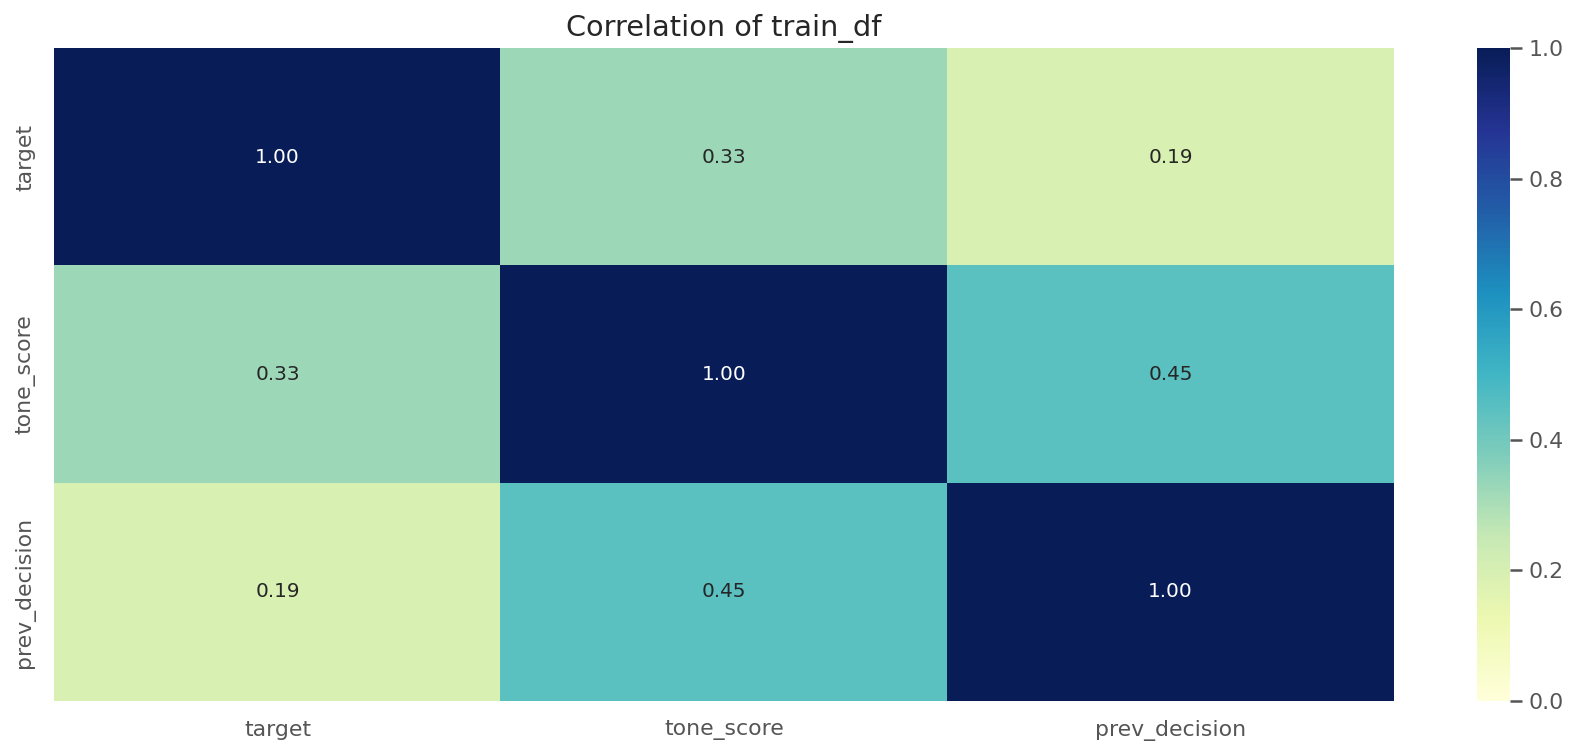

In [17]:
# Show corelations to next_decision
fig, ax1 = plt.subplots(1, 1, figsize=(15,6))

corr_columns = ['target', 'tone_score', 'prev_decision']
sns.heatmap(train_df2[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Correlation of train_df")

plt.show()

# Tokenize and vectorize

## `Task #1: implement tokenization functions`

In [49]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()

    # ------------------------------------------------------------
    return # import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

words = ['gave', 'went', 'going', 'dating']
for word in words:
    print(word + "-->" + WordNetLemmatizer().lemmatize(word, 'v'))
    # ------------------------------------------------------------

def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it loser case

        # ------------------------------------------------------------
        # put your code here
        # ------------------------------------------------------------

        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized

gave-->give
went-->go
going-->go
dating-->date


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Tokenize text_df

In [50]:
tokenized_org = tokenize_df(train_df2)
print('len(tokenized_org): ', len(tokenized_org))


  0%|          | 0/222 [00:00<?, ?it/s]

len(tokenized_org):  222


In [52]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))


TypeError: ignored

In [53]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabrary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

len(all_words_org):  888
None
len(counts_org):  1
bow_org[:20] [None]


In [54]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

222


In [55]:
# Add to the dataframe
train_df2['tokenized'] = tokenized_org
train_df2['token_ids'] = token_ids_org

## Lemmatize sentiment

In [56]:
# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['Word'] = [lemmatize_word(str(word)) for word in lemma_sentiment_df['Word']]
# Drop duplicates
lemma_sentiment_df = lemma_sentiment_df.drop_duplicates('Word').reset_index(drop=True)
lemma_sentiment_df
# Sentiment list
sent_cols = ['Word'] + sentiments
lemma_sentiment_df = lemma_sentiment_df[sent_cols]
lemma_sentiment_df


,Word,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining
0,None,0,0,0,0,0,0,0


## Tfidf 

## `Task #2: implement tfidf vectorize function`

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """

    # ------------------------------------------------------------
    # put your code here
    # ------------------------------------------------------------
    
    return tfidf.toarray()

### Text dataframe

In [ ]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df[lemma_sentiment_df[sentiment] > 0]['Word'], lemma_docs_org)
        for sentiment in sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))

222
1165


In [ ]:
len(sentiment_tfidf_org)

7

In [ ]:
for sentiment in sentiments:
    train_df2['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
train_df2

,date,target,prev_decision,GDP_diff_prev,PMI,EMP_diff_prev,RSALES_diff_year,UNEMP_diff_prev,HSALES_diff_year,Inertia_diff,...,neg_words,tokenized,token_ids,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_Strong_Modal,tfidf_Weak_Modal,tfidf_Constraining
0,1993-02-03,2,0.0,1.042880,54.2,0.204078,2.094256,0.000000,16.487455,0.0,...,"[discontinuance, cease, questions, question, u...","[a, meet, federal, open, market, committee, ho...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.12222595615035266,...","[0.0, 0.04898915926224665, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6690617929816143, 0.44680804060777707,...","[0.07484740139060027, 0.09403011891380149, 0.0...","[0.0, 0.0, 0.1041187354100462, 0.3228501956942..."
1,1993-03-23,2,0.0,1.042880,55.2,0.227699,2.476367,-2.739726,-5.477308,0.0,...,"[unemployment, sharply, depressed, claims, une...","[a, meet, federal, open, market, committee, ho...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.15140759135201734, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.13598475519121936,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8341448643141...","[0.0, 0.3188230120888446, 0.0, 0.2393063496985...","[0.0, 0.0, 0.0, 0.1018242281970586, 0.20467887..."
2,1993-05-18,2,0.0,0.166979,50.2,0.274560,4.026033,1.428571,28.388278,0.0,...,"[slowed, diminished, disappointing, losses, de...","[a, meet, federal, open, market, committee, ho...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1615832635099...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1854026570252996, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.12291713597238177, 0.0, 0.369043011446...","[0.0, 0.0, 0.0, 0.1614500138247738, 0.0, 0.0, ..."
3,1993-07-07,2,0.0,0.166979,49.6,0.163700,4.151271,-1.408451,9.563758,0.0,...,"[slow, slowed, declined, unemployment, decline...","[a, meet, federal, open, market, committee, ho...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.20284800524127294,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.130...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.5152450956026172, 0.0, 0.0, 0.684...","[0.0, 0.10481856152290948, 0.0, 0.216359241854...","[0.0, 0.0, 0.12721827674623867, 0.0, 0.0, 0.0,..."
4,1993-08-17,2,0.0,0.582113,50.2,0.276300,5.072074,-1.428571,4.465710,0.0,...,"[decline, slower, unemployment, dropped, decli...","[a, meet, federal, open, market, committee, ho...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.09183537390931196,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.138...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5498977757378...","[0.0, 0.0, 0.0, 0.058010230424701104, 0.0, 0.5...","[0.0, 0.0, 0.0, 0.0948257666236327, 0.19061113..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2021-06-16,2,0.0,1.533890,61.6,0.308928,22.314413,-3.333333,4.815864,0.0,...,"[concerns, restated, cautioned, diminish, conc...","[the, federal, reserve, central, bank, unite, ...","[125, 3, 11, 472, 43, 261, 262, 230, 1066, 327...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05720165540178099, 0.0, 0.0, 0.0, 0.0, 0.29...","[0.0, 0.04649759152805863, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.44474130540884665,...","[0.054622571502403836, 0.0, 0.0, 0.54082438020...","[0.0, 0.0, 0.3420483105258455, 0.2651548819606..."
218,2021-07-28,2,0.0,1.533890,60.9,0.383765,1

## Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

## `Task #3: implement get_cosine_similarity function`

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    # ------------------------------------------------------------
    return  # put your code here
    # ------------------------------------------------------------


In [ ]:
sentiment_tfidf = sentiment_tfidf_org.copy()
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

221


In [ ]:
for sentiment in sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    train_df2['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
train_df2

,date,target,prev_decision,GDP_diff_prev,PMI,EMP_diff_prev,RSALES_diff_year,UNEMP_diff_prev,HSALES_diff_year,Inertia_diff,...,tfidf_Strong_Modal,tfidf_Weak_Modal,tfidf_Constraining,cos_sim_Negative,cos_sim_Positive,cos_sim_Uncertainty,cos_sim_Litigious,cos_sim_Strong_Modal,cos_sim_Weak_Modal,cos_sim_Constraining
0,1993-02-03,2,0.0,1.042880,54.2,0.204078,2.094256,0.000000,16.487455,0.0,...,"[0.0, 0.6690617929816143, 0.44680804060777707,...","[0.07484740139060027, 0.09403011891380149, 0.0...","[0.0, 0.0, 0.1041187354100462, 0.3228501956942...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1993-03-23,2,0.0,1.042880,55.2,0.227699,2.476367,-2.739726,-5.477308,0.0,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8341448643141...","[0.0, 0.3188230120888446, 0.0, 0.2393063496985...","[0.0, 0.0, 0.0, 0.1018242281970586, 0.20467887...",0.566430,0.794461,0.683198,0.100371,0.000000,0.842286,0.797517
2,1993-05-18,2,0.0,0.166979,50.2,0.274560,4.026033,1.428571,28.388278,0.0,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.12291713597238177, 0.0, 0.369043011446...","[0.0, 0.0, 0.0, 0.1614500138247738, 0.0, 0.0, ...",0.585265,0.835972,0.811946,0.773065,0.000000,0.855663,0.913650
3,1993-07-07,2,0.0,0.166979,49.6,0.163700,4.151271,-1.408451,9.563758,0.0,...,"[0.0, 0.0, 0.5152450956026172, 0.0, 0.0, 0.684...","[0.0, 0.10481856152290948, 0.0, 0.216359241854...","[0.0, 0.0, 0.12721827674623867, 0.0, 0.0, 0.0,...",0.547593,0.683579,0.708844,0.852608,0.515245,0.832532,0.898192
4,1993-08-17,2,0.0,0.582113,50.2,0.276300,5.072074,-1.428571,4.465710,0.0,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5498977757378...","[0.0, 0.0, 0.0, 0.058010230424701104, 0.0, 0.5...","[0.0, 0.0, 0.0, 0.0948257666236327, 0.19061113...",0.599937,0.713266,0.765418,0.876313,0.211688,0.893373,0.884770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2021-06-16,2,0.0,1.533890,61.6,0.308928,22.314413,-3.333333,4.815864,0.0,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.44474130540884665,...","[0.054622571502403836, 0.0, 0.0, 0.54082438020...","[0.0, 0.0, 0.3420483105258455, 0.2651548819606...",0.784132,0.866304,0.749801,0.905177,0.791934,0.734782,0.665711
218,2021-07-28,2,0.0,1.533890,60.9,0.383765,13.352829,1.724138,-22.559653,0.0,...,"[0.0, 0.0, 0.2432436576835114, 0.0, 0.0, 0.969...","[0.11021133285129463, 0.0, 0.0, 0.649532808039...","[0.0, 0.0, 0.1835245761851193, 0.1422677318897...",0.838158,0.859975,0.784779,0.537571,0.431384,0.959935,0.889100
219,2021-09-22,2,0.0,1.640747,59.7,0.353173,9.952513,-3.703704,-33.783784,0.0,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0919650125906386, 0.0, 0.0, 0.5636776452745...","[0.0, 0.0, 0.16190673311521722, 0.062754820571...",0.798513,0.895551,0.912057,0.498915,0.000000,0.936659,0.809038
220,2021-11-03,2,0.0,0.570948,60.5,0.288624,8.474656,-9.615385,-26.135217,0.0,...,"[0.0, 0.0, 0.3320960021001917, 0.0, 0.0, 0.882...","[0.12187897937627878, 0.07655773420935025, 0.0...","[0.0, 0.0, 0.20590372334788581, 0.0, 0.0, 0.0,...",0.808287,0.856874,0.799014,0.806060,0.332096,0.945002,0.886729


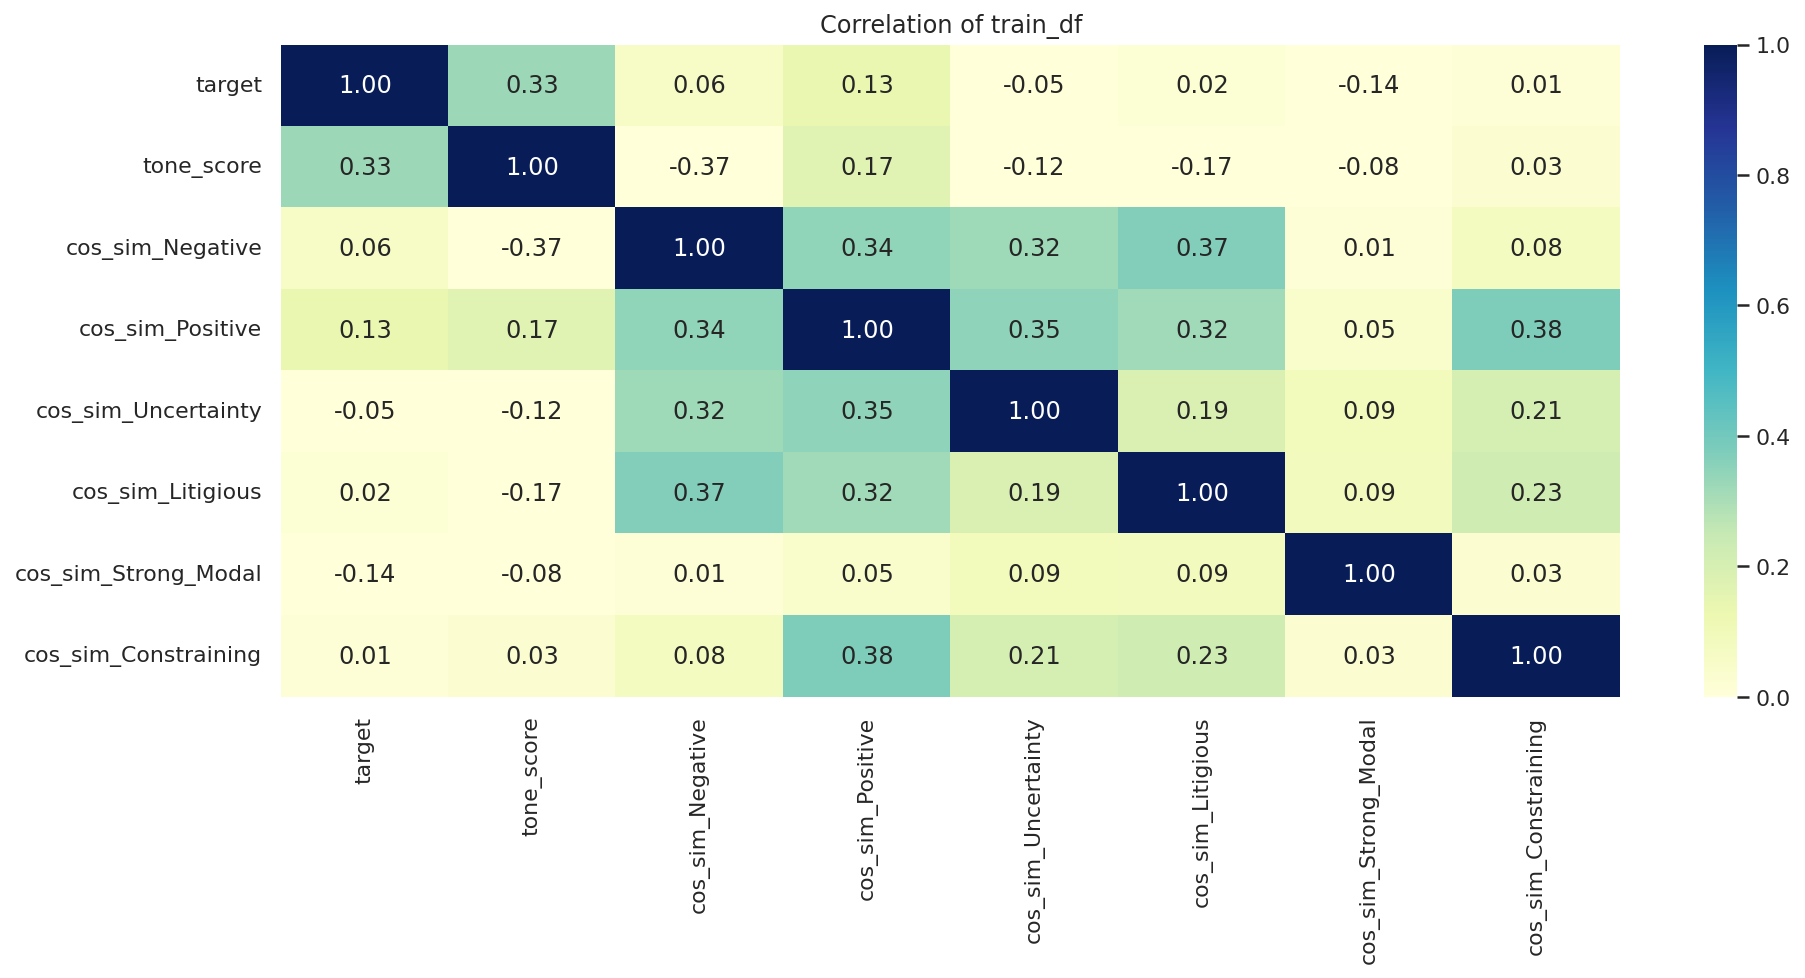

In [ ]:
# Show corelations to target
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone_score', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_Strong_Modal', 'cos_sim_Constraining']
sns.heatmap(train_df2[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

# Modeling and Training
## Common Functions

In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

## A. Cosin Similarity
### Train and Test Data

In [ ]:
train_df2.columns

Index(['date', 'target', 'prev_decision', 'GDP_diff_prev', 'PMI',
       'EMP_diff_prev', 'RSALES_diff_year', 'UNEMP_diff_prev',
       'HSALES_diff_year', 'Inertia_diff', 'Balanced_diff', 'text',
       'tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words',
       'neg_words', 'tokenized', 'token_ids', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_Strong_Modal', 'tfidf_Weak_Modal', 'tfidf_Constraining',
       'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty',
       'cos_sim_Litigious', 'cos_sim_Strong_Modal', 'cos_sim_Weak_Modal',
       'cos_sim_Constraining'],
      dtype='object')

In [ ]:

# X and Y data used
Y_data = train_df2['target']
X_data = train_df2[nontext_columns + ['tone_score', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 
                                     'cos_sim_Litigious', 'cos_sim_Strong_Modal', 'cos_sim_Constraining']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

### Train

## `Task #4: train any classifier using the above data`

In [ ]:
# ------------------------------------------------------------
# put your code here
# ------------------------------------------------------------

## `Task #5: predict and evluate with test data`

In [ ]:
# ------------------------------------------------------------
# put your code here
# ------------------------------------------------------------

## `Task #6: calcuate and plot the confusion maxrix`

In [ ]:
# ------------------------------------------------------------
# put your code here
# ------------------------------------------------------------